# XG Boosted Trees for age prediction

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats
from statsmodels.tsa import stattools
from sklearn import preprocessing
import xgboost as xgb

In [4]:
feats = np.load('Age_feats_15_aligned.npy')
labels = np.load('../processed_datasets/Age_y_15_aligned.npy')
ids = np.load('../processed_datasets/Age_ids_15_aligned.npy')
feats.shape, labels.shape, ids.shape

((499758, 14, 15), (499758,), (499758,))

In [ ]:
#Optional, select only accel and gyro
feats = feats[:, :, [0, 1, 2, 4, 5, 6]]
feats.shape

In [5]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

#Flatten the features
feats = feats.reshape((feats.shape[0], -1))

#Remove nans
valid_idxs = ~np.isnan(feats).any(axis=1)
feats = feats[valid_idxs]
labels = labels[valid_idxs]
ids = ids[valid_idxs]

print(feats.shape, labels.shape)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels, train_ids, test_ids = train_test_split(feats, labels, ids, test_size = 0.25, random_state = 42, shuffle = False)

#Scale the features
train_features_scaled = preprocessing.scale(train_features)
test_features_scaled = preprocessing.scale(test_features)

print('Training Features Shape:', train_features_scaled.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features_scaled.shape)
print('Testing Labels Shape:', test_labels.shape)

(497972, 210) (497972,)
Training Features Shape: (373479, 210)
Training Labels Shape: (373479,)
Testing Features Shape: (124493, 210)
Testing Labels Shape: (124493,)


In [6]:
# The baseline predictions are the train set averages
baseline_preds = np.zeros_like(train_labels) + np.mean(train_labels)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - train_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  13.3


In [7]:
# Import the model we are using
from xgboost import XGBRegressor
# Instantiate model
model = XGBRegressor(n_estimators=100, objective='reg:squarederror', gamma=0, reg_alpha=0, reg_lambda=1, tree_method='gpu_exact')
model.fit(train_features_scaled, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_exact',
             verbosity=1)

In [8]:
# Use the model's predict method on the train data
predictions = model.predict(train_features_scaled)
# Calculate the absolute errors
errors = abs(predictions - train_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'years.')

Mean Absolute Error: 11.85 years.


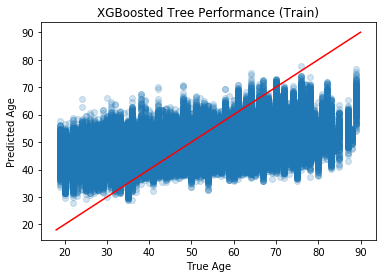

(SpearmanrResult(correlation=0.4506389054231979, pvalue=0.0),
 (0.4667598634778, 0.0))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot([18, 90], [18, 90], 'r')
plt.scatter(train_labels, predictions, alpha = 0.2)
plt.title('XGBoosted Tree Performance (Train)')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

import scipy
scipy.stats.spearmanr(predictions, b=train_labels), scipy.stats.pearsonr(x=predictions, y=train_labels)

In [10]:
# Use the forest's predict method on the test data
predictions = model.predict(test_features_scaled)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'years.')

Mean Absolute Error: 12.89 years.


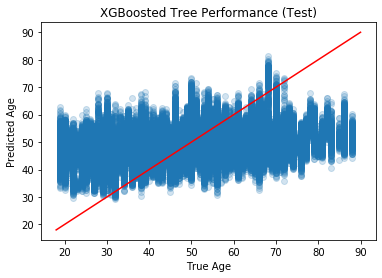

(SpearmanrResult(correlation=0.28544444880377795, pvalue=0.0),
 (0.30386093282942844, 0.0))

In [11]:
plt.figure()
plt.plot([18, 90], [18, 90], 'r')
plt.scatter(test_labels, predictions, alpha = 0.2)
plt.title('XGBoosted Tree Performance (Test)')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.show()

import scipy
scipy.stats.spearmanr(predictions, b=test_labels), scipy.stats.pearsonr(x=predictions, y=test_labels)

In [12]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 68.27 %.


In [13]:
feature_list = np.arange(210)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                  182 Importance: 0.15680047869682312
Variable:                   63 Importance: 0.11036953330039978
Variable:                   73 Importance: 0.09884145110845566
Variable:                   72 Importance: 0.09544138610363007
Variable:                  152 Importance: 0.05568255856633186
Variable:                  183 Importance: 0.036328475922346115
Variable:                  120 Importance: 0.03630750626325607
Variable:                   66 Importance: 0.03441769257187843
Variable:                  172 Importance: 0.030283719301223755
Variable:                   59 Importance: 0.029076941311359406
Variable:                   68 Importance: 0.028957538306713104
Variable:                   31 Importance: 0.02853473834693432
Variable:                  184 Importance: 0.026966899633407593
Variable:                   12 Importance: 0.024229133501648903
Variable:                   94 Importance: 0.023939380422234535
Variable:                  122 Importance: 0.020

# Userwise Accuracy

In [14]:
unique_ids = np.unique(test_ids)
print(f'There are {len(unique_ids)} unique ids in our val set.')

overall_y_true = []
overall_y_pred = []

for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(test_ids == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    pred = np.mean(predictions[usr_idxs])
    true = test_labels[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')
    
    overall_y_true.append(true)
    overall_y_pred.append(pred)
    
overall_abs_err = np.abs(np.array(overall_y_true) - np.array(overall_y_pred))

There are 833 unique ids in our val set.


In [15]:
np.mean(overall_abs_err)

13.00186523584043

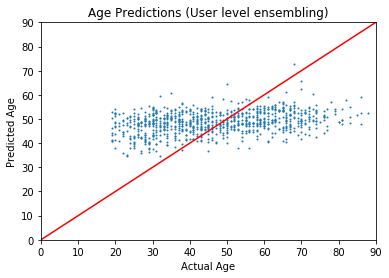

SpearmanrResult(correlation=0.3078917131942608, pvalue=9.476822519404007e-20) (0.3311952687229049, 8.956105881359205e-23)


In [17]:
plt.figure()
plt.scatter(overall_y_true, overall_y_pred, s = 1)
plt.plot([0, 90], [0, 90], 'r-')
plt.xlim([0, 90])
plt.ylim([0, 90])
plt.title("Age Predictions (User level ensembling)")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.show()

import scipy
print(scipy.stats.spearmanr(overall_y_true, b=overall_y_pred), 
      scipy.stats.pearsonr(x=overall_y_true, y=overall_y_pred))